In [1]:
import sys

In [2]:
sys.path.append('..')

In [3]:
import os
import cdsapi

import json
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotnine as p9
import seaborn as sns

In [4]:
from tqdm.auto import tqdm
from collections import defaultdict
#from sdcpy.scale_dependent_correlation import SDCAnalysis
import warnings

c:\Users\brand\anaconda3\envs\tfm_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


## SDC Analysis for groups of contiguous countries

In [5]:
world = pd.read_pickle('../data/world_shape.pkl')

In [6]:
country_to_iso = world[['country', 'iso3']].drop_duplicates()

In [7]:
covid_df = pd.read_csv('../data/covid/covid19_world.csv')

In [8]:
country_groups = pd.read_csv('../data/country_groups.csv')

In [9]:
lon_lat_country = pd.read_csv('../data/coords_region_0.5.csv').merge(country_to_iso)

In [10]:
lon_lat_group = lon_lat_country.merge(country_groups)

In [11]:
processed_path = "../data/climate/grid_0.5/processed/"
relevant_files = [f for f in os.listdir(processed_path) if (f[:9] >= '2021_12_0') & (f[:9] <= '2023_01_2')]
climate_df = pd.concat([pd.read_pickle(f'{processed_path}{f}') for f in relevant_files])

In [12]:
if not os.path.exists('../data/processed_05_grid.csv'):
    dens = (
        xr.load_dataset("../data/gpw_v4_population_density_rev11_2pt5_min.nc")
        .sel({"raster": 4})
        .to_dataframe()
        .dropna()
        .reset_index()
        .drop(columns="raster")
        .rename(
            columns={
                "Population Density, v4.11 (2000, 2005, 2010, 2015, 2020): 2.5 arc-minutes": "density"
            }
        )
        # Rounding to closest .5 degree
        .assign(latitude=lambda dd: (dd.latitude * 2).round() / 2)
        .assign(longitude=lambda dd: (dd.longitude * 2).round() / 2)
        .groupby(["latitude", "longitude"])
        .mean()
        .reset_index()
    )

    dens.to_csv('../data/processed_05_grid.csv', index=False)
dens = pd.read_csv("../data/processed_05_grid.csv")

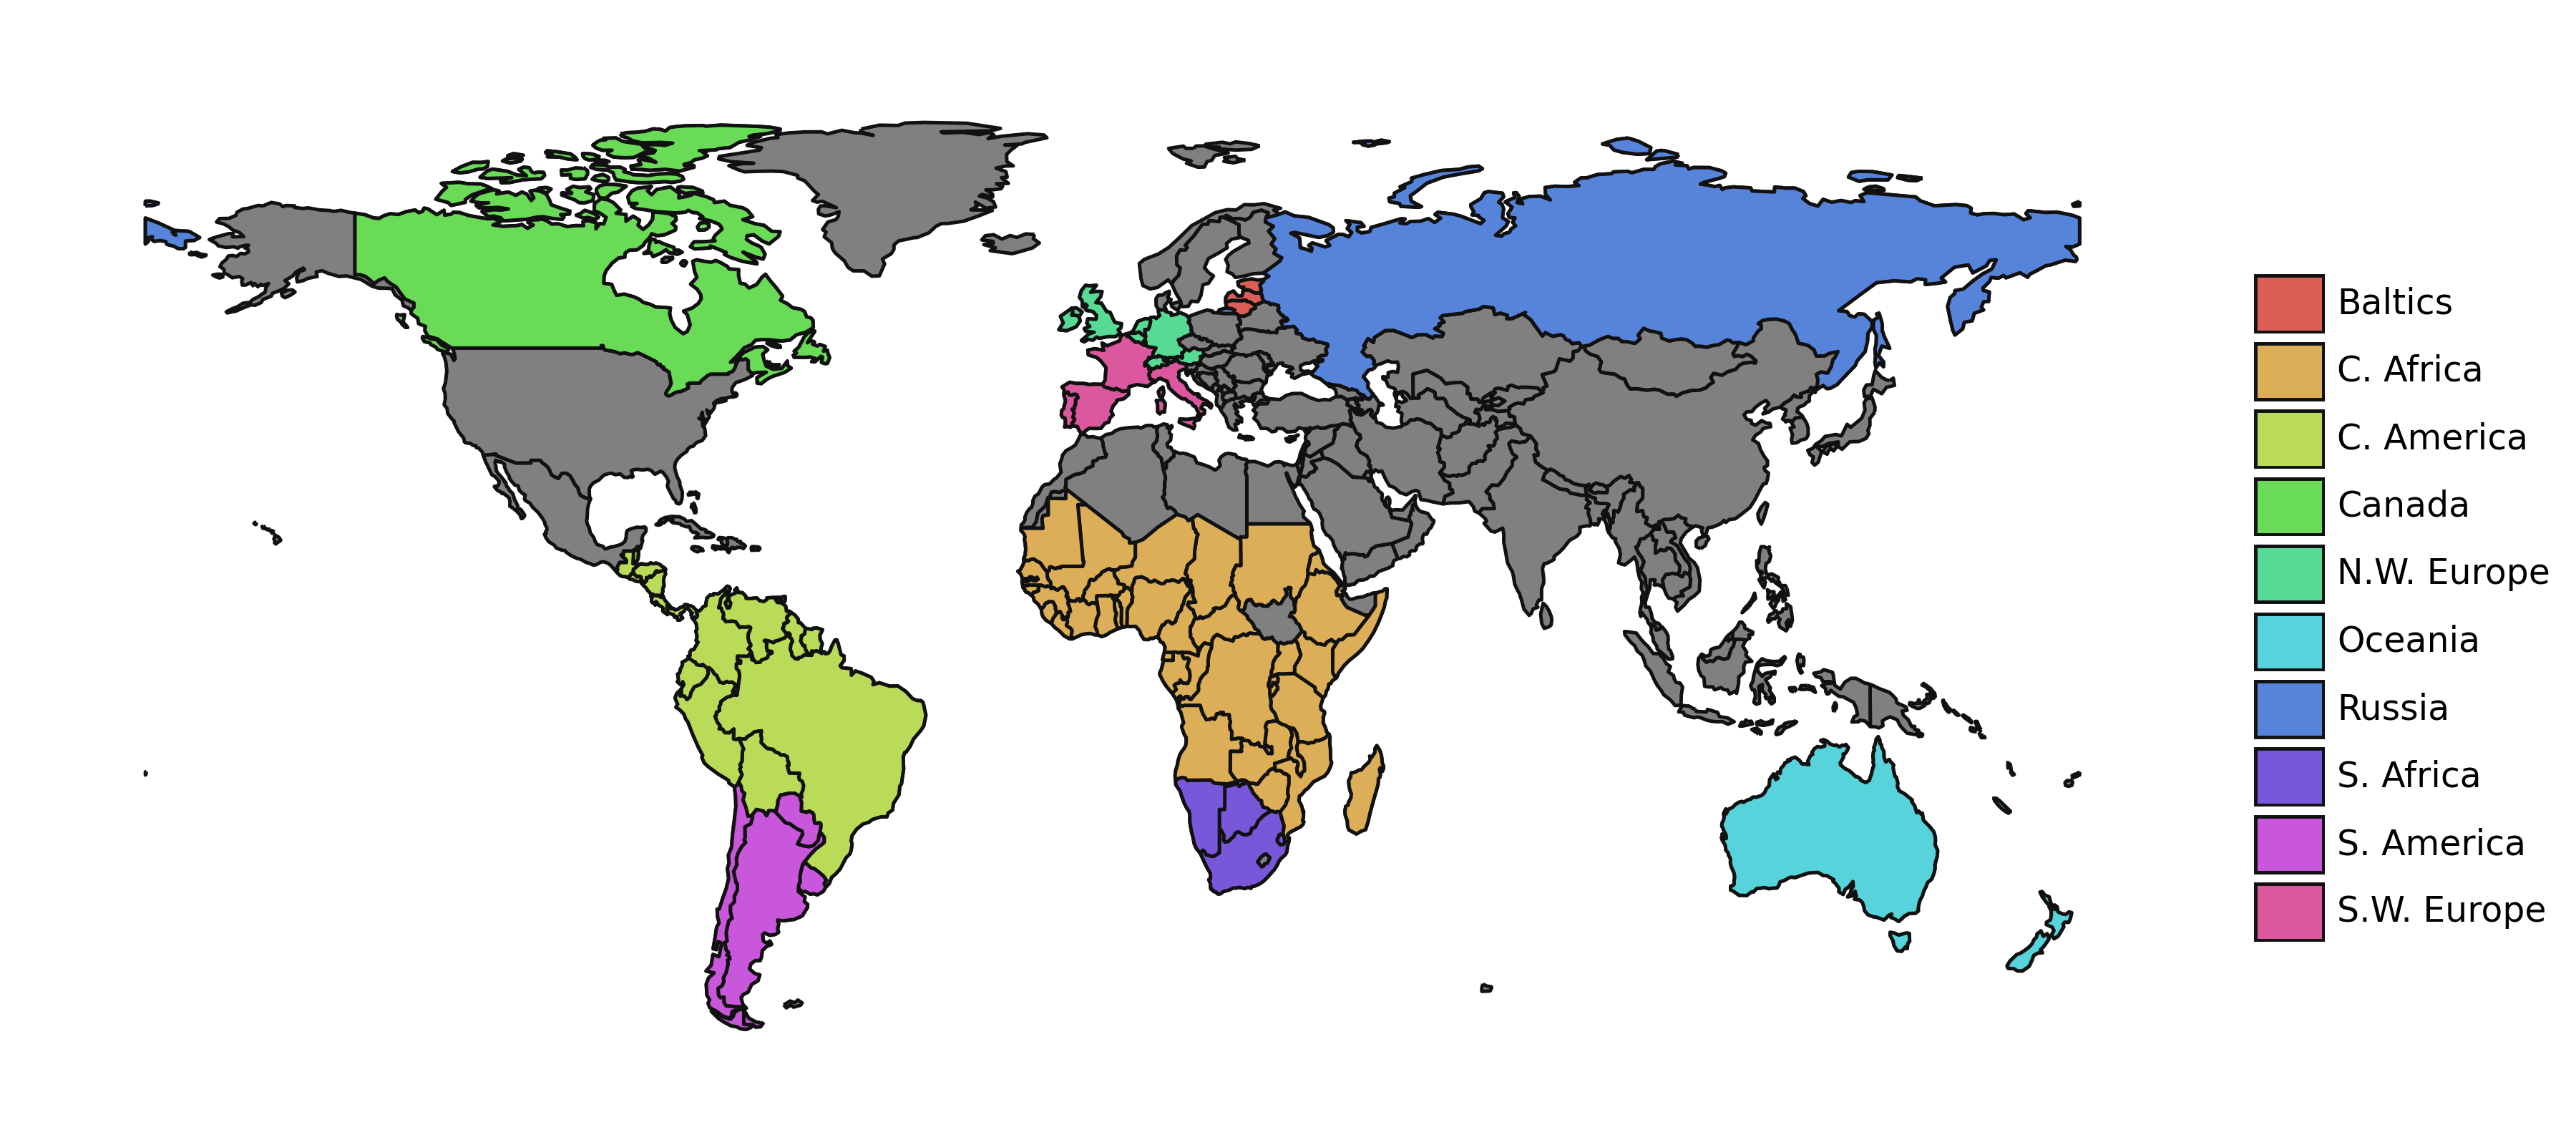

<Figure Size: (1800 x 800)>

In [13]:
f = (world
     .merge(country_groups)
     .pipe(lambda dd: p9.ggplot(dd)
       + p9.geom_map(data=world, fill='gray')
       + p9.geom_map(p9.aes(fill='group'))
       + p9.ylim(-55, None)
       + p9.labs(fill='')
       + p9.theme_void()
       + p9.theme(figure_size=(9, 4), dpi=200, legend_key_height=15)
      )
)
f

In [14]:
weighted_cells = (dens.merge(lon_lat_group)
    .groupby('group', as_index=False)
    .apply(lambda gdd: gdd.assign( relative_weight=lambda gdd: gdd.density / gdd.density.sum()))
    .reset_index(drop=True)
)

C:\Users\brand\AppData\Local\Temp\ipykernel_59632\1766496956.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


In [15]:
weighted_climate_df = (
        weighted_cells.dropna()
        .merge(climate_df, on=["latitude", "longitude"])
        .assign(temperature=lambda dd: dd.temperature * dd.relative_weight,
                absolute_humidity=lambda dd: dd.absolute_humidity * dd.relative_weight)
        .groupby(['group', "date"], as_index=False)
        [["temperature", "absolute_humidity"]]
        .agg({"temperature": "sum", "absolute_humidity": "sum"})
)

In [16]:
groups_covid_ts = \
(covid_df
 .merge(country_groups)
 .assign(date=lambda dd: pd.to_datetime(dd.date))
 .groupby('group')
 .apply(lambda dd: 
        dd.set_index('date')
        .resample('D')
        .sum()
        ['new_cases']
        #.rolling(center=True, window=7)
        #.mean()
        .loc['2021-12-19': '2023-01-31'])
)

C:\Users\brand\AppData\Local\Temp\ipykernel_59632\1214416737.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


In [17]:
groups_weather_ts = \
(weighted_climate_df
 .assign(date=lambda dd: pd.to_datetime(dd.date))
 .query('"2021-12-19" <= date <= "2023-01-31"')
 .set_index(['group', 'date'])
)

In [18]:
CV_LABELS = {'absolute_humidity': 'Absolute Humidity [g/m³]',
             'temperature': 'Temperature [°C]',
             'relative_humidity': 'Relative Humidity [%]',
             'total_precipitation': 'Total Precipitation [mm]'}

In [ ]:
import openpyxl
from sdcpy.scale_dependent_correlation import SDCAnalysis
#from utils.sdc_modified import SDCAnalysis

w = 200
out_dir = '../results'
for group in tqdm(country_groups.group.unique(), desc='Processing Groups', leave=False):
    for weather_variable in ['temperature', 'absolute_humidity']:
        covid_ts = groups_covid_ts.loc[group]
        weather_ts = groups_weather_ts.loc[group][weather_variable]
        sdc = SDCAnalysis(ts1=weather_ts,
                          ts2=covid_ts,
                          fragment_size=w,
                          method='spearman',
                          max_lag=0,
                          min_lag=-21)
        sdc.to_excel(f"{out_dir}/tables/SDC_country_groups/sdc_{w}_{group}_{weather_variable}.xlsx")
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            sdc.combi_plot(dpi=120,
                           figsize=(7, 7),
                           title=f"SDC with s={w}: \nCOVID19 daily confirmed cases in" +
                                 f" {group} ~ {weather_variable}",
                           xlabel=CV_LABELS[weather_variable],
                           ylabel=f"Confirmed COVID19 cases in {group}",
                           alpha=0.05,
                           max_lag=0,
                           min_lag=-21,
                           max_r=1,
                           wspace=.35,
                           hspace=.35)
        plt.savefig(f"{out_dir}/figures/SDC_country_groups/sdc_{w}_{group}_{weather_variable}.png")
        plt.savefig(f"{out_dir}/figures/SDC_country_groups/sdc_{w}_{group}_{weather_variable}.pdf")
        

## SDC Analysis for European countries

In [28]:
world = pd.read_pickle('../data/world_shape.pkl')

In [29]:
country_to_iso = world[['country', 'iso3']].drop_duplicates()

In [30]:
covid_df = pd.read_csv('../data/covid/covid19_world.csv')

In [31]:
lon_lat_country = pd.read_csv('../data/coords_region_0.5.csv').merge(country_to_iso)

In [32]:
processed_path = "../data/climate/grid_0.5/processed/"
relevant_files = [f for f in os.listdir(processed_path) if (f[:9] >= '2021_12_0') & (f[:9] <= '2023_01_2')]
climate_df = pd.concat([pd.read_pickle(f'{processed_path}{f}') for f in relevant_files])

In [33]:
if not os.path.exists('../data/processed_05_grid.csv'):
    dens = (
        xr.load_dataset("../data/gpw_v4_population_density_rev11_2pt5_min.nc")
        .sel({"raster": 4})
        .to_dataframe()
        .dropna()
        .reset_index()
        .drop(columns="raster")
        .rename(
            columns={
                "Population Density, v4.11 (2000, 2005, 2010, 2015, 2020): 2.5 arc-minutes": "density"
            }
        )
        # Rounding to closest .5 degree
        .assign(latitude=lambda dd: (dd.latitude * 2).round() / 2)
        .assign(longitude=lambda dd: (dd.longitude * 2).round() / 2)
        .groupby(["latitude", "longitude"])
        .mean()
        .reset_index()
    )

    dens.to_csv('../data/processed_05_grid.csv', index=False)
dens = pd.read_csv("../data/processed_05_grid.csv")

In [34]:
eur_countries = lon_lat_country[lon_lat_country['country'].isin(['Germany', 'Spain', 'France', 'United Kingdom', 'Italy'])]

In [35]:
eur_covid_ts = (
    covid_df
    .query("country in ['Germany', 'Spain', 'France', 'United Kingdom', 'Italy']")
    .assign(date=lambda dd: pd.to_datetime(dd['date']))
    .set_index('date')
    .sort_index()
    [['country','new_cases']]
    .loc['2021-12-19':'2023-01-31']
)

In [36]:
eur_weighted_cells = (dens.merge(lon_lat_country)
    .groupby('country', as_index=False)
    .apply(lambda gdd: gdd.assign( relative_weight=lambda gdd: gdd.density / gdd.density.sum()))
    .reset_index(drop=True)
)

C:\Users\brand\AppData\Local\Temp\ipykernel_59632\3096511853.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


In [37]:
eur_weighted_climate_df = (
        eur_weighted_cells.dropna()
        .merge(climate_df, on=["latitude", "longitude"])
        .assign(temperature=lambda dd: dd.temperature * dd.relative_weight,
                absolute_humidity=lambda dd: dd.absolute_humidity * dd.relative_weight)
        .groupby(["date","country_x"], as_index=False)
        [["temperature", "absolute_humidity"]]
        .agg({"temperature": "sum", "absolute_humidity": "sum"})
)

In [38]:
eur_weather_ts = (
    eur_weighted_climate_df
    .query("country_x in ['Germany', 'Spain', 'France', 'United Kingdom', 'Italy']")
    .assign(date=lambda dd: pd.to_datetime(dd['date']))
    .query('"2021-12-19" <= date <= "2023-01-31"')
    .set_index('date')
)

In [39]:
CV_LABELS = {'absolute_humidity': 'Absolute Humidity [g/m³]',
             'temperature': 'Temperature [°C]',
             'relative_humidity': 'Relative Humidity [%]',
             'total_precipitation': 'Total Precipitation [mm]'}

In [42]:
from utils.sdc_modified import SDCAnalysis
w = 105
out_dir = '../results'
for country in tqdm(['Germany', 'Spain', 'France', 'United Kingdom', 'Italy'], desc='Processing Countries', leave=False):
    for weather_variable in ['temperature', 'absolute_humidity']:
        country_covid_ts = eur_covid_ts[eur_covid_ts['country'] == country]['new_cases']
        country_weather_ts = eur_weather_ts[eur_weather_ts['country_x'] == country][weather_variable]
        sdc = SDCAnalysis(ts1=country_weather_ts,
                          ts2=country_covid_ts,
                          fragment_size=w,
                          method='spearman',
                          max_lag=0,
                          min_lag=-21)
        sdc.to_excel(f"{out_dir}/tables/SDC_eur_countries/sdc_{w}_{country}_{weather_variable}.xlsx")
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            sdc.combi_plotMOD(dpi=120,
                           figsize=(7, 7),
                           title=f"SDC with s={w}: \nCOVID19 daily confirmed cases in" +
                                 f" {country} ~ {weather_variable}",
                           xlabel=CV_LABELS[weather_variable],
                           ylabel=f"Confirmed COVID19 cases in {country}",
                           alpha=0.05,
                           max_lag=0,
                           min_lag=-21,
                           max_r=1,
                           wspace=.35,
                           hspace=.35)
        plt.savefig(f"{out_dir}/figures/SDC_eur_countries/sdc_{w}_{country}_{weather_variable}.png")
        plt.savefig(f"{out_dir}/figures/SDC_eur_countries/sdc_{w}_{country}_{weather_variable}.pdf")
        plt.close()

Processing Countries:   0%|          | 0/5 [00:00<?, ?it/s]













































































































































































































































































































































































































































































































































































































































Processing Countries:  20%|██        | 1/5 [01:38<06:35, 98.86s/it]





























































































































































































































































## SDC Analysis for EU regions

In [24]:
lon_lat_region = pd.read_csv('../data/coords_region_EU_regions.csv')

In [25]:
covid_eu = pd.read_csv('../data/covid/covid_eu.csv')

In [26]:
processed_path = "../data/climate/grid_0.25/processed/"
relevant_files = [f for f in os.listdir(processed_path) if (f[:9] >= '2021_12_0') & (f[:9] <= '2023_01_2')]
eu4_weather = pd.concat([pd.read_pickle(f'{processed_path}{f}') for f in relevant_files])

In [27]:
if not os.path.exists('../data/processed_025_grid.csv'):
    dens = (
        xr.load_dataset("../data/gpw_v4_population_density_rev11_2pt5_min.nc")
        .sel({"raster": 4})
        .to_dataframe()
        .dropna()
        .reset_index()
        .drop(columns="raster")
        .rename(
            columns={
                "Population Density, v4.11 (2000, 2005, 2010, 2015, 2020): 2.5 arc-minutes": "density"
            }
        )
        # Here I am first, rounding up to .25 resolution and then shifting the map so that longitudes
        # are on the -180 +180 domain. 
        .assign(latitude=lambda dd: (dd.latitude * 4).round() / 4)
        .assign(longitude=lambda dd: (dd.longitude * 4).round() / 4)
        .groupby(["latitude", "longitude"])
        .mean()
        .reset_index()
    )
    dens.to_csv('../data/processed_025_grid.csv', index=False)
dens = pd.read_csv("../data/processed_025_grid.csv")

In [28]:
weighted_cells = (
    dens.merge(lon_lat_region)
    .groupby('region', as_index=False)
    .apply(
        lambda gdd: gdd.assign(
            relative_weight=lambda gdd: gdd.density / gdd.density.sum()
        )
    )
    .reset_index(drop=True)
)

C:\Users\brand\AppData\Local\Temp\ipykernel_53760\433515362.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


In [29]:
weighted_climate_df = (
    weighted_cells
    .dropna()
    .merge(eu4_weather.merge(lon_lat_region), on=["latitude", "longitude", "region"])
    .assign(
        temperature=lambda dd: dd.temperature * dd.relative_weight,
        absolute_humidity=lambda dd: dd.absolute_humidity * dd.relative_weight
    )
    .groupby(['region', "date"])
    .agg({"temperature": "sum",
          "absolute_humidity": "sum",
          "relative_humidity": "sum",
          "total_precipitation": "sum"})
    .reset_index()
    .assign(region=lambda dd: dd.region.replace({'Valle d’Aosta/Vallée d’Aoste': "Valle d'Aosta"}))
    .melt(['region', 'date'])
    .assign(region=lambda dd: dd.region.str.replace('/', '-'))
    .sort_values(['region', 'date'])
    .query('"2021-12-19" <= date <= "2023-01-31"')
    
)
weighted_climate_df.query('variable == "temperature"').to_csv('../fit/weather_sdc_eu.csv')

In [30]:
covid_sdc_df = (covid_eu
                .query('"2021-12-19" <= date <= "2023-01-31"')
                .loc[lambda dd: dd.region.isin(weighted_climate_df.region.unique())]
)
covid_sdc_df.to_csv('../fit/covid_sdc_eu.csv')

In [31]:
with open('../data/regions_country.json', 'r') as json_file:
    regions_country = json.load(json_file)

In [ ]:
from utils.sdc_modified import SDCAnalysis

ranges_df = []
errors_list = {}
window = 14
sdcs = {}

for region in tqdm(covid_sdc_df.region.unique(), desc="Processing regions"):
    country = regions_country[region]
    for var in ['temperature', 'absolute_humidity']:
            
            w = (weighted_climate_df
                 .query(f'region=="{region}" & variable=="{var}"')
                 .set_index('date')
                 .value)

            c = (covid_sdc_df
                 .query(f'region=="{region}"')
                 .set_index('date')
                 .new_cases
                 .rolling(center=True, window=7)
                 .mean()
                 .dropna())
     
            # Ensure the indices are in datetime format
            w.index = pd.to_datetime(w.index)
            c.index = pd.to_datetime(c.index)   
        
            bin_size = 2 if var == 'absolute_humidity' else 3
            max_bin = 22 if var == 'absolute_humidity' else 32
            min_bin = 0 if var == 'absolute_humidity' else -6
            sdc = SDCAnalysis(w, c, fragment_size=window, min_lag=-21, max_lag=0, method='spearman')
           
            sdcs[f'{region}_{var}'] = sdc

            ranges_df.append(sdc.get_ranges_df(bin_size=bin_size, max_bin=max_bin, min_bin=min_bin)
                                      .assign(region=region, var=var, country=regions_country[region]
                                              ))

In [33]:
covid_sdc_df.iso3.unique()

array(['DEU', 'FRA', 'GBR', 'ITA'], dtype=object)

In [56]:
ranges_df = pd.concat(ranges_df)
ranges_df.to_csv('../results/tables/ranges_eu_regions.csv', index=False)

In [57]:
ranges_df = pd.read_csv('../results/tables/ranges_eu_regions.csv')

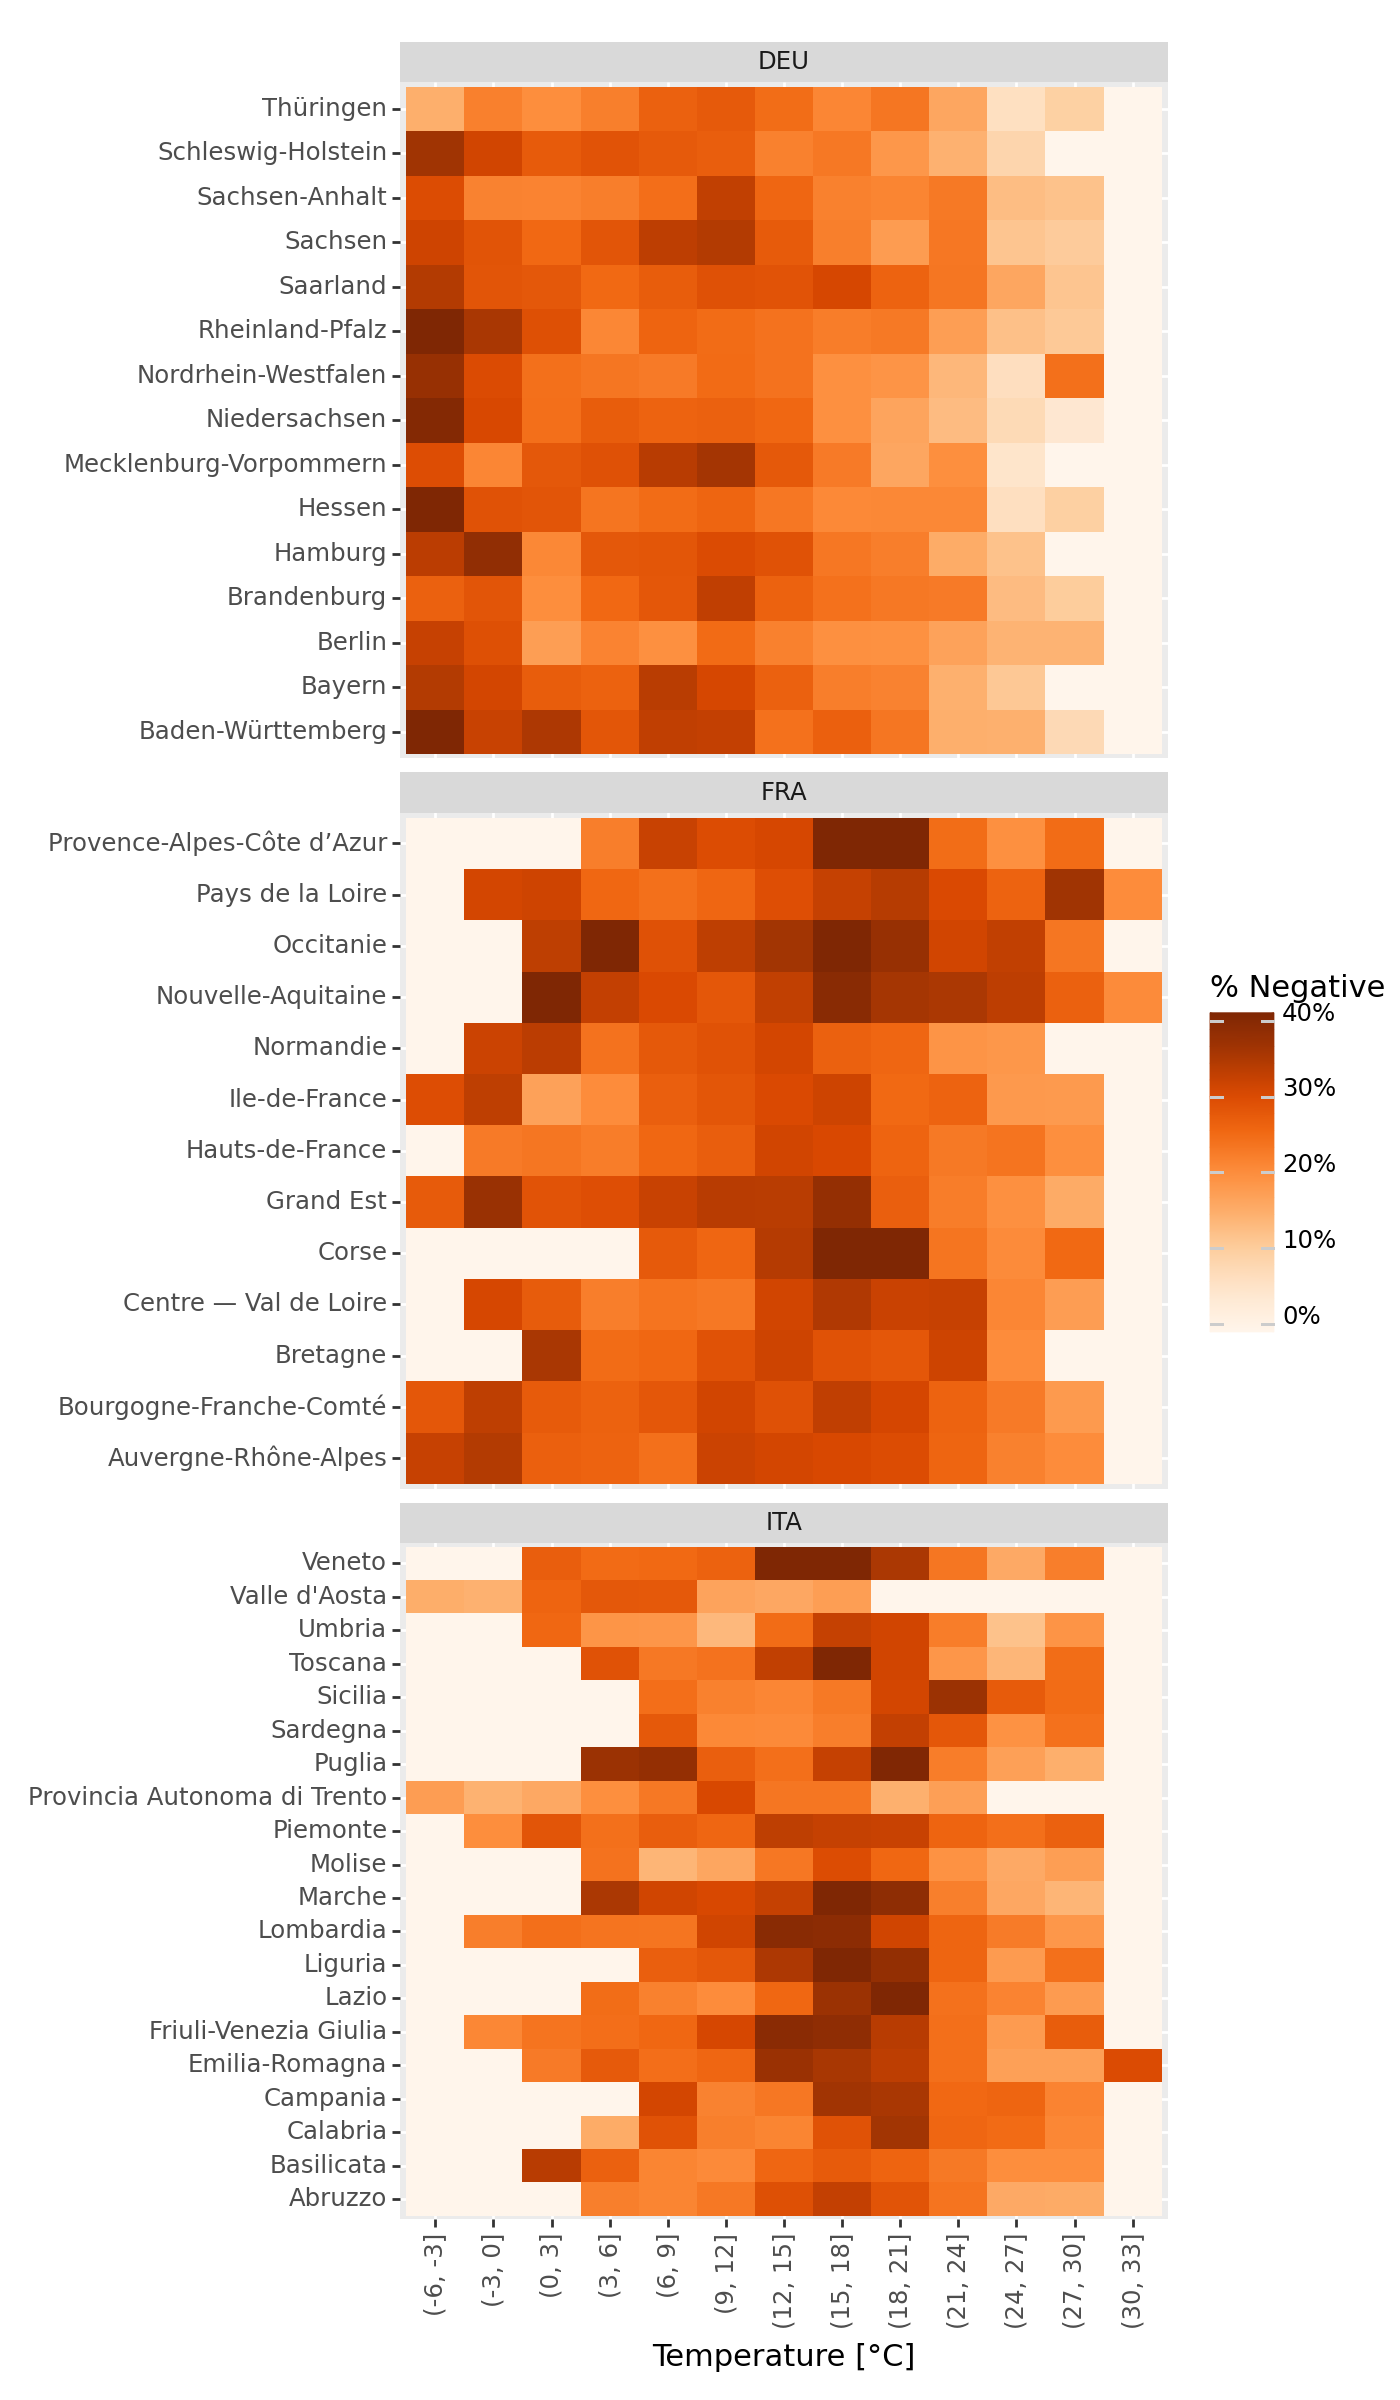

In [70]:
from mizani.formatters import date_format, percent_format

CV_LABELS = {'absolute_humidity': 'Absolute Humidity [g/m³]',
             'temperature': 'Temperature [°C]',
             'relative_humidity': 'Relative Humidity [%]',
             'total_precipitation': 'Total Precipitation [mm]'}

wv = 'temperature'

df = (ranges_df
 .loc[lambda dd: dd['var']==wv]
 .loc[lambda dd: dd.direction=='Negative']
 .groupby(['cat_value', 'region', 'country'])
 [['n', 'counts']]
 .sum()
 .reset_index()
 .assign(freq=lambda dd: (dd['counts'] / dd['n']).fillna(0))
)

# Convert cat_value to a categorical type with a specified order
cat_order = ['(-6, -3]', '(-3, 0]', '(0, 3]', '(3, 6]', '(6, 9]', '(9, 12]', '(12, 15]',
             '(15, 18]', '(18, 21]', '(21, 24]', '(24, 27]', '(27, 30]', '(30, 33]']
df['cat_value'] = pd.Categorical(df['cat_value'], categories=cat_order, ordered=True)

# Create a new plot
plot = (p9.ggplot(df)
        + p9.aes('cat_value', 'region', fill='freq')
        + p9.geom_tile()
        + p9.facet_wrap('country', ncol=1, scales='free_y')
        + p9.theme(figure_size=(7, 12), axis_text_x=p9.element_text(rotation=90))
        + p9.scale_fill_continuous('Oranges', labels=percent_format(), limits=(0, .4))
        + p9.labs(x=CV_LABELS[wv], fill='% Negative', y='')
        )

# Display the plot
print(plot)

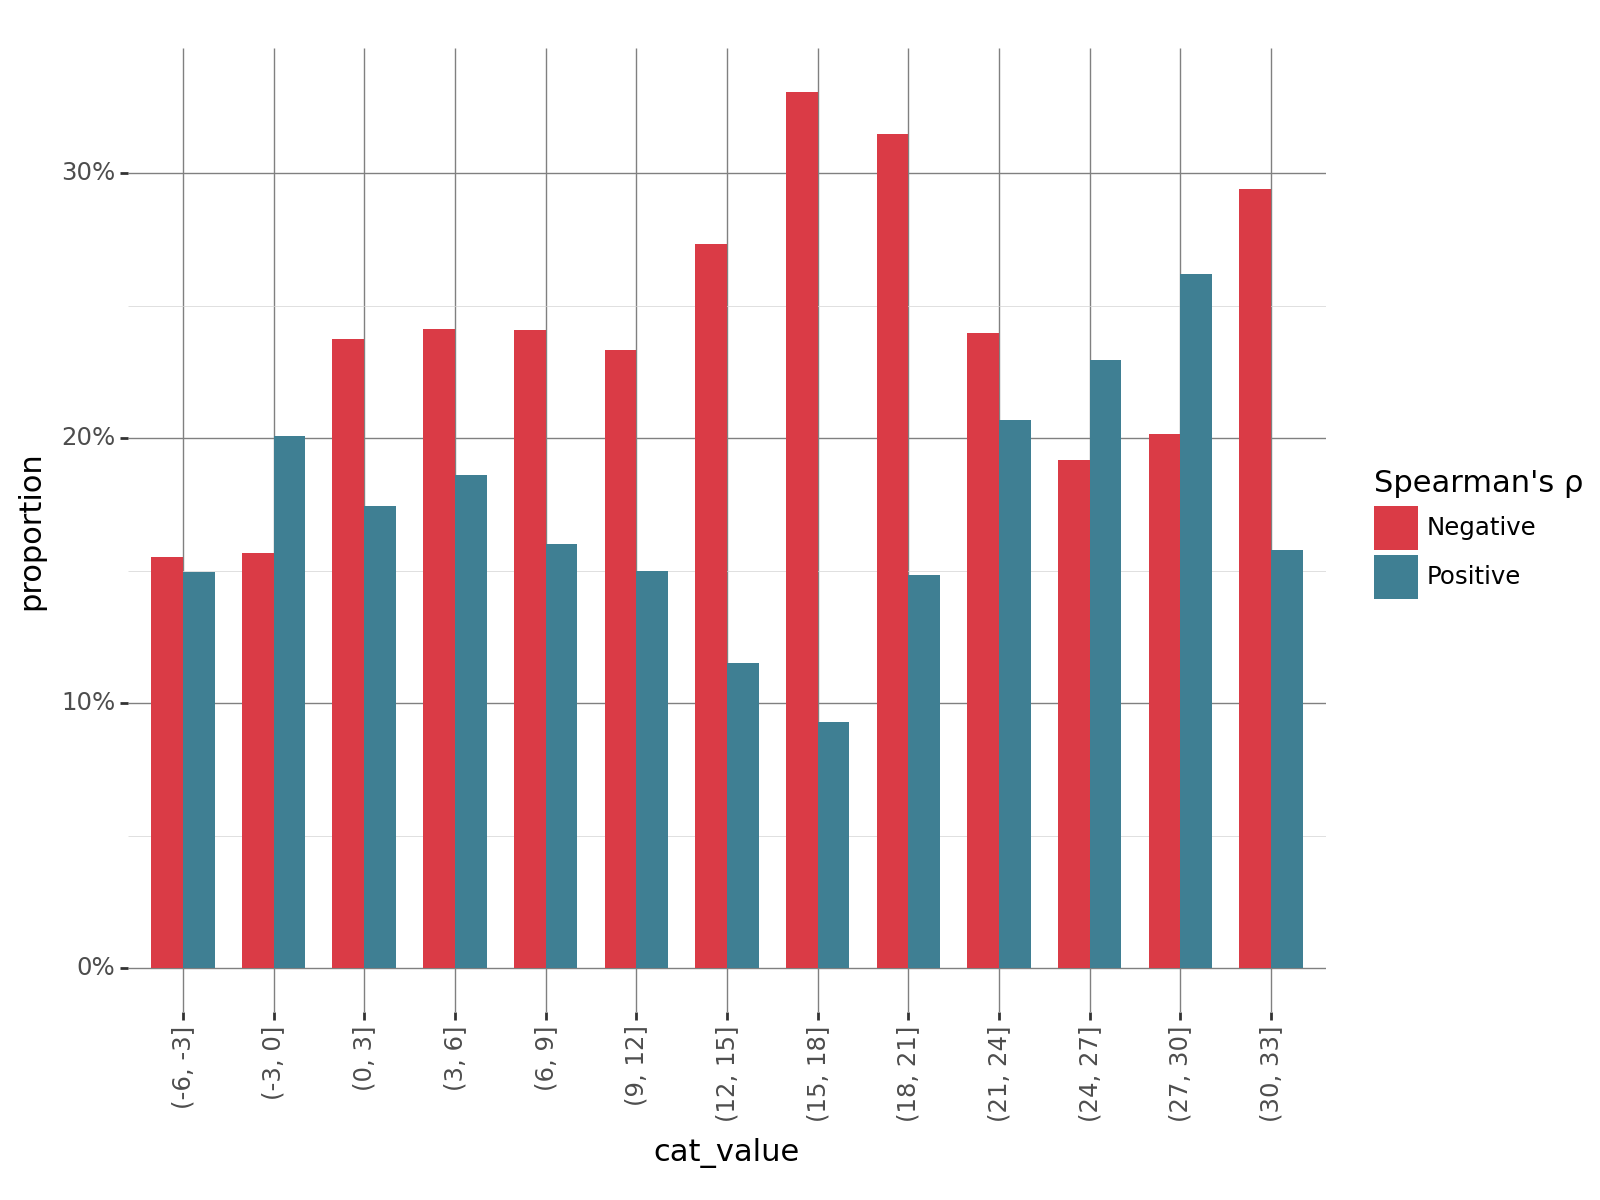

In [74]:
# Filter data for Italy and temperature
df_italy_temp = ranges_df[(ranges_df['country'] == 'ITA') & (ranges_df['var'] == 'temperature')]

# Calculate proportions of each direction within each temperature range
df_proportions = (df_italy_temp
                  .groupby(['cat_value', 'direction'])
                  .agg({'counts': 'sum', 'n': 'sum'})
                  .reset_index()
                  .assign(proportion=lambda x: x['counts'] / x['n'])
                 )
df_proportions = df_proportions[df_proportions['direction'] != 'NS']

direction_colors = {
    'Negative': '#da3b46',
    'Positive': '#3f7f93',
}

# Convert cat_value to a categorical type with a specified order
df_proportions['cat_value'] = pd.Categorical(df_proportions['cat_value'], categories=cat_order, ordered=True)

# Create the bar plot
plot = (p9.ggplot(df_proportions)
        + p9.aes(x='cat_value', y='proportion', fill='direction')
        + p9.geom_bar(stat='identity', position='dodge', width = 0.7)
        + p9.scale_fill_manual(values=direction_colors)
        + p9.theme(
            figure_size=(8, 6),
            axis_text_x=p9.element_text(rotation=90),
            panel_background=p9.element_rect(fill='white'),
            panel_grid_major=p9.element_line(color='grey', size=0.5),
            panel_grid_minor=p9.element_line(color='lightgrey', size=0.25)
        )
        + p9.scale_y_continuous(labels=percent_format())
        + p9.labs(fill="Spearman's ρ")
       )

# Display the plot
print(plot)

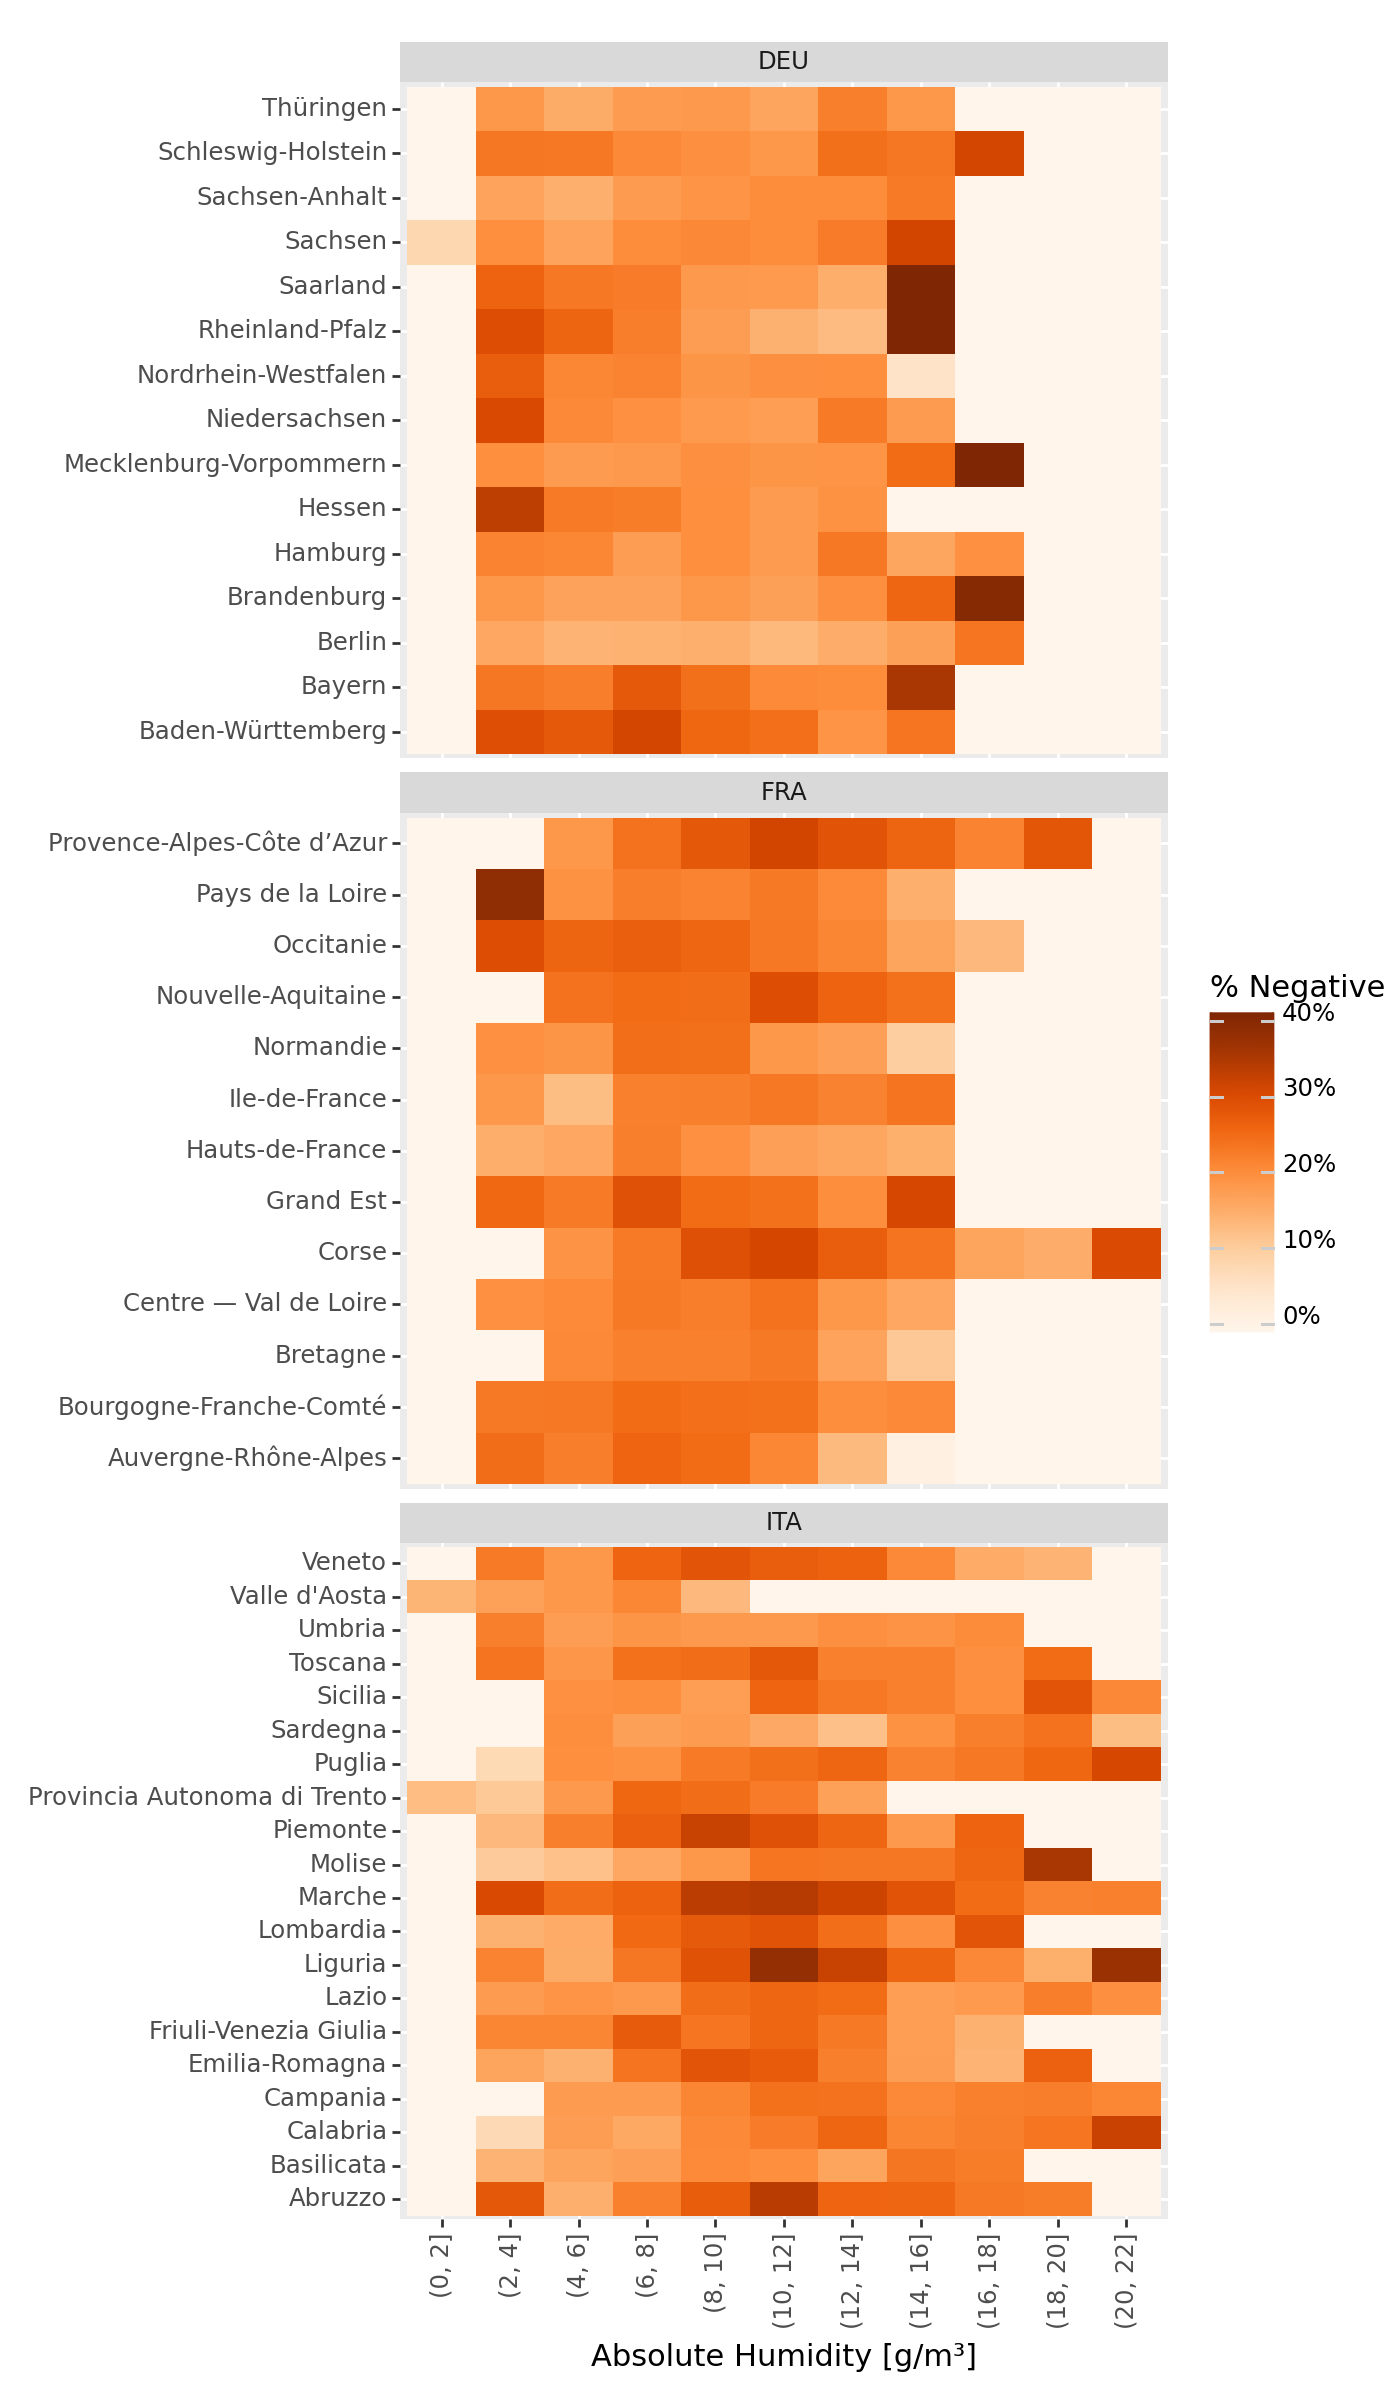

In [80]:
from mizani.formatters import date_format, percent_format

CV_LABELS = {'absolute_humidity': 'Absolute Humidity [g/m³]',
             'temperature': 'Temperature [°C]',
             'relative_humidity': 'Relative Humidity [%]',
             'total_precipitation': 'Total Precipitation [mm]'}

wv = 'absolute_humidity'


# Convert cat_value to a categorical type with a specified order
cat_order = ['(0, 2]', '(2, 4]', '(4, 6]', '(6, 8]', '(8, 10]', '(10, 12]', '(12, 14]',
             '(14, 16]', '(16, 18]', '(18, 20]', '(20, 22]']
df['cat_value'] = pd.Categorical(df['cat_value'], categories=cat_order, ordered=True)

# Filter and process data
df = (ranges_df
 .loc[ranges_df['var'] == wv]
 .loc[ranges_df['direction'] == 'Negative']
 .groupby(['cat_value', 'region', 'country'])
 [['n', 'counts']]
 .sum()
 .reset_index()
 .assign(freq=lambda dd: (dd['counts'] / dd['n']).fillna(0))
)

# Convert cat_value to a categorical type with a specified order
df['cat_value'] = pd.Categorical(df['cat_value'], categories=cat_order, ordered=True)

# Create the plot
plot = (p9.ggplot(df)
        + p9.aes('cat_value', 'region', fill='freq')
        + p9.geom_tile()
        + p9.facet_wrap('country', ncol=1, scales='free_y')
        + p9.theme(figure_size=(7, 12), axis_text_x=p9.element_text(rotation=90))
        + p9.scale_fill_continuous('Oranges', labels=percent_format(), limits=(0, .4))
        + p9.labs(x=CV_LABELS[wv], fill='% Negative', y='')
       )

# Display the plot
print(plot)

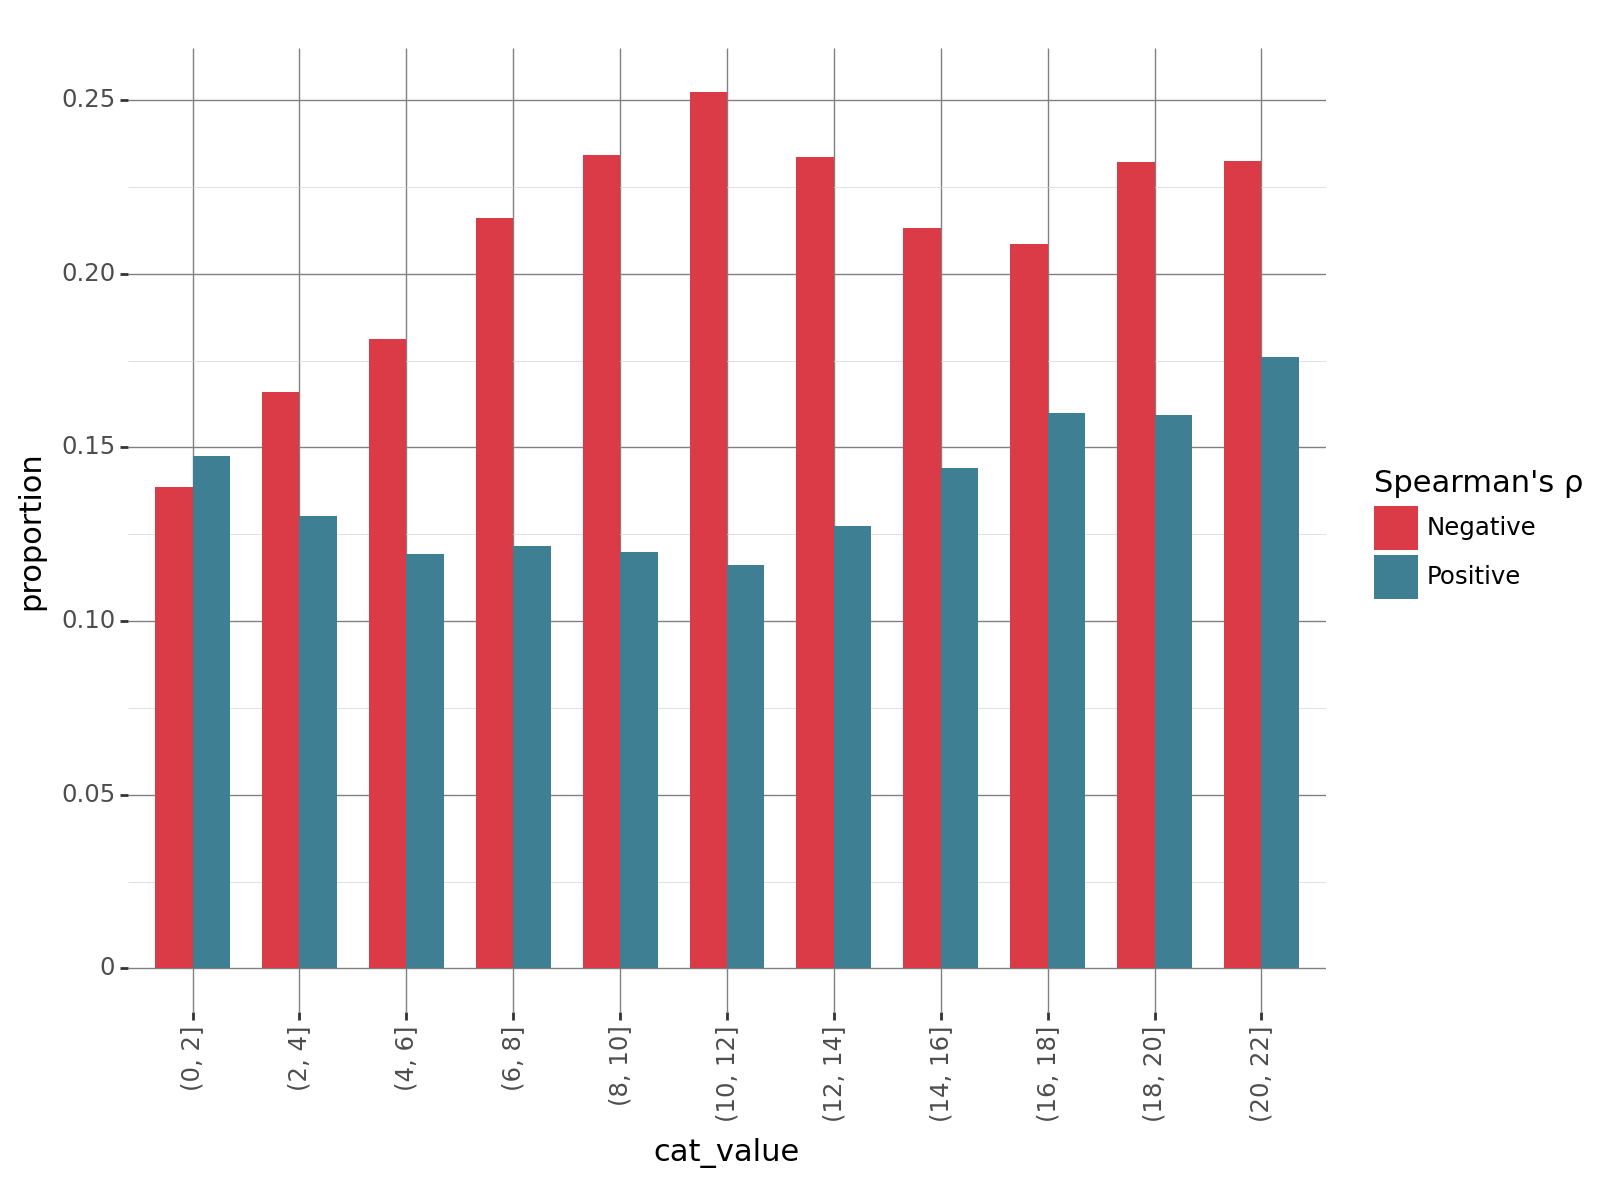

In [82]:
df_italy_ah = ranges_df[(ranges_df['country'] == 'ITA') & (ranges_df['var'] == 'absolute_humidity')]

df_proportions = (df_italy_ah
                  .groupby(['cat_value', 'direction'])
                  .agg({'counts': 'sum', 'n': 'sum'})
                  .reset_index()
                  .assign(proportion=lambda x: x['counts'] / x['n'])
                 )
df_proportions = df_proportions[df_proportions['direction'] != 'NS']

direction_colors = {
    'Negative': '#da3b46',
    'Positive': '#3f7f93',
}

# Convert cat_value to a categorical type with a specified order
df_proportions['cat_value'] = pd.Categorical(df_proportions['cat_value'], categories=cat_order, ordered=True)

plot = (p9.ggplot(df_proportions)
        + p9.aes(x='cat_value', y='proportion', fill='direction')
        + p9.geom_bar(stat='identity', position='dodge', width = 0.7)
        + p9.scale_fill_manual(values=direction_colors)
        + p9.theme(
            figure_size=(8, 6),
            axis_text_x=p9.element_text(rotation=90),
            panel_background=p9.element_rect(fill='white'),
            panel_grid_major=p9.element_line(color='grey', size=0.5),
            panel_grid_minor=p9.element_line(color='lightgrey', size=0.25)
        )
        + p9.labs(fill="Spearman's ρ")
       )

print(plot)

C:\Users\brand\AppData\Local\Temp\ipykernel_60172\3533560700.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


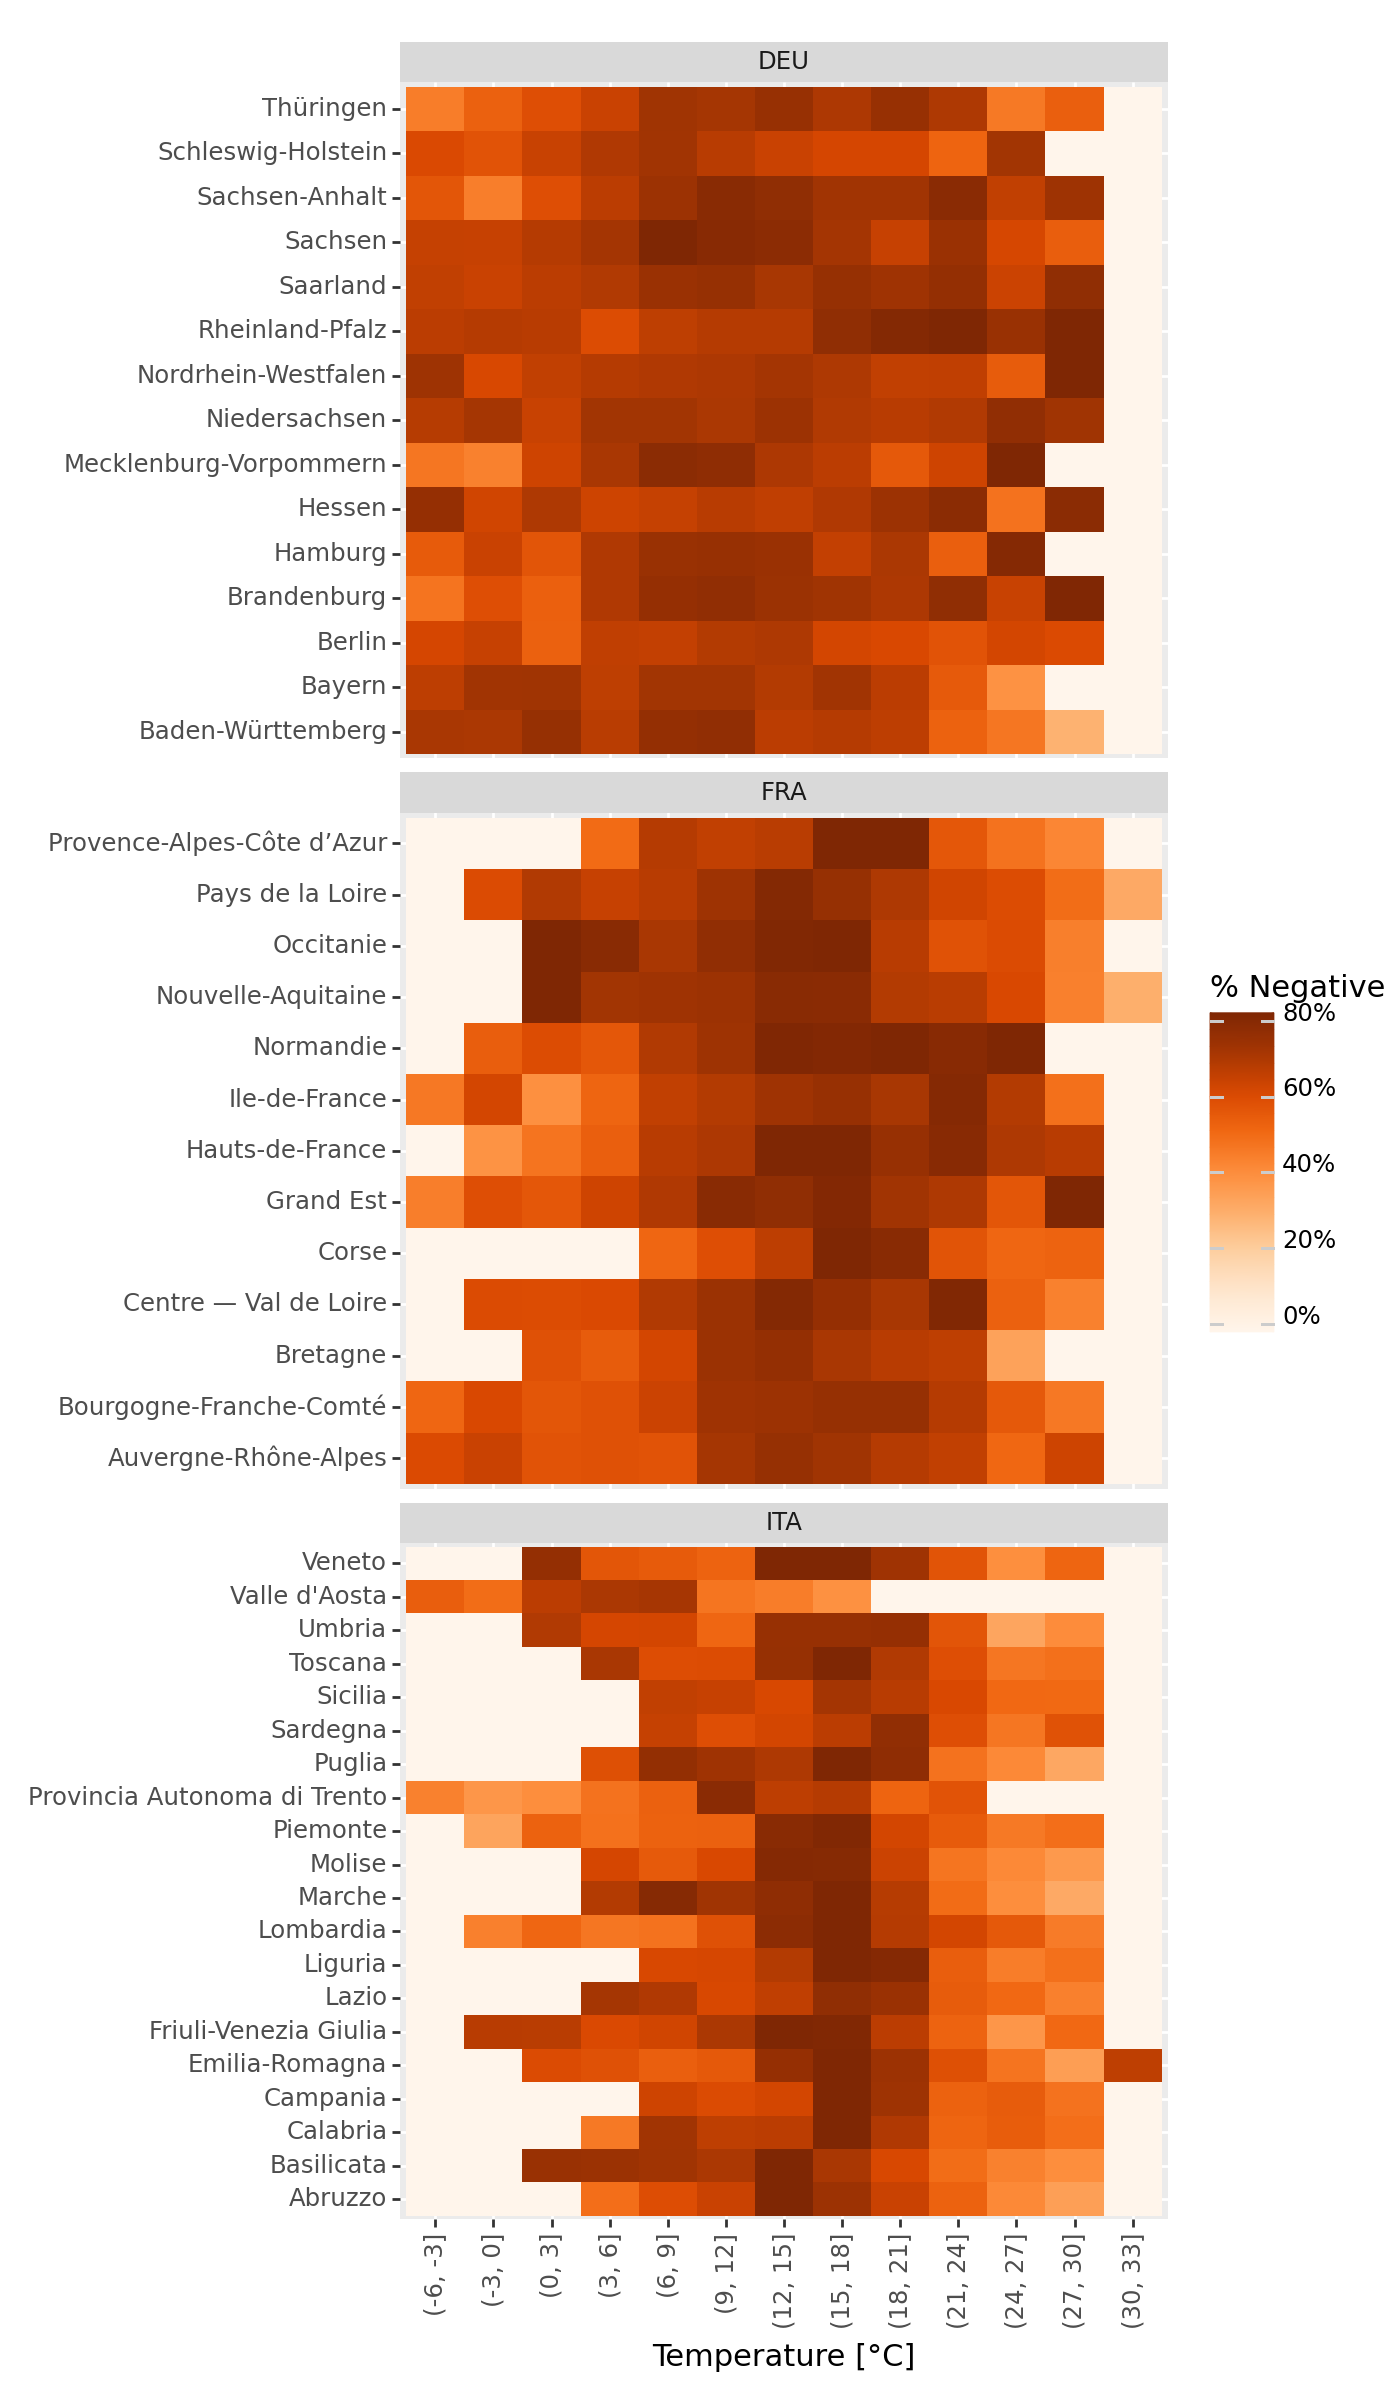

In [83]:
wv = 'temperature'

# Define the order for cat_value
cat_order = ['(-6, -3]', '(-3, 0]', '(0, 3]', '(3, 6]', '(6, 9]', '(9, 12]', '(12, 15]',
             '(15, 18]', '(18, 21]', '(21, 24]', '(24, 27]', '(27, 30]', '(30, 33]']

# Process the data
df = (
    ranges_df
    .loc[lambda dd: dd['var'] == wv]  # Filter by variable of interest
    .groupby(['cat_value', 'region', 'country'])
    .apply(lambda x: x.assign(n=x.loc[x['direction'] != 'NS', 'counts'].sum()))  # Calculate n excluding 'NS'
    .reset_index(drop=True)
    .assign(negative=lambda dd: dd.loc[dd['direction'] == 'Negative', 'counts'] / dd['n'])  # Calculate % Negative
    .loc[lambda dd: dd['direction'] == 'Negative']  # Filter for Negative direction only
    .fillna(value={'negative': 0})  # Replace NaN with 0 for % Negative
)

# Convert cat_value to a categorical type with a specified order
df['cat_value'] = pd.Categorical(df['cat_value'], categories=cat_order, ordered=True)

# Create the plot
plot = (p9.ggplot(df)
        + p9.aes('cat_value', 'region', fill='negative')
        + p9.geom_tile()
        + p9.facet_wrap('country', ncol=1, scales='free_y')
        + p9.theme(figure_size=(7, 12), axis_text_x=p9.element_text(rotation=90))
        + p9.scale_fill_continuous('Oranges', labels=percent_format(), limits=(0, 0.8))
        + p9.labs(x=CV_LABELS[wv], fill='% Negative', y='')
        )

# Display the plot
print(plot)

C:\Users\brand\AppData\Local\Temp\ipykernel_60172\2683367022.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


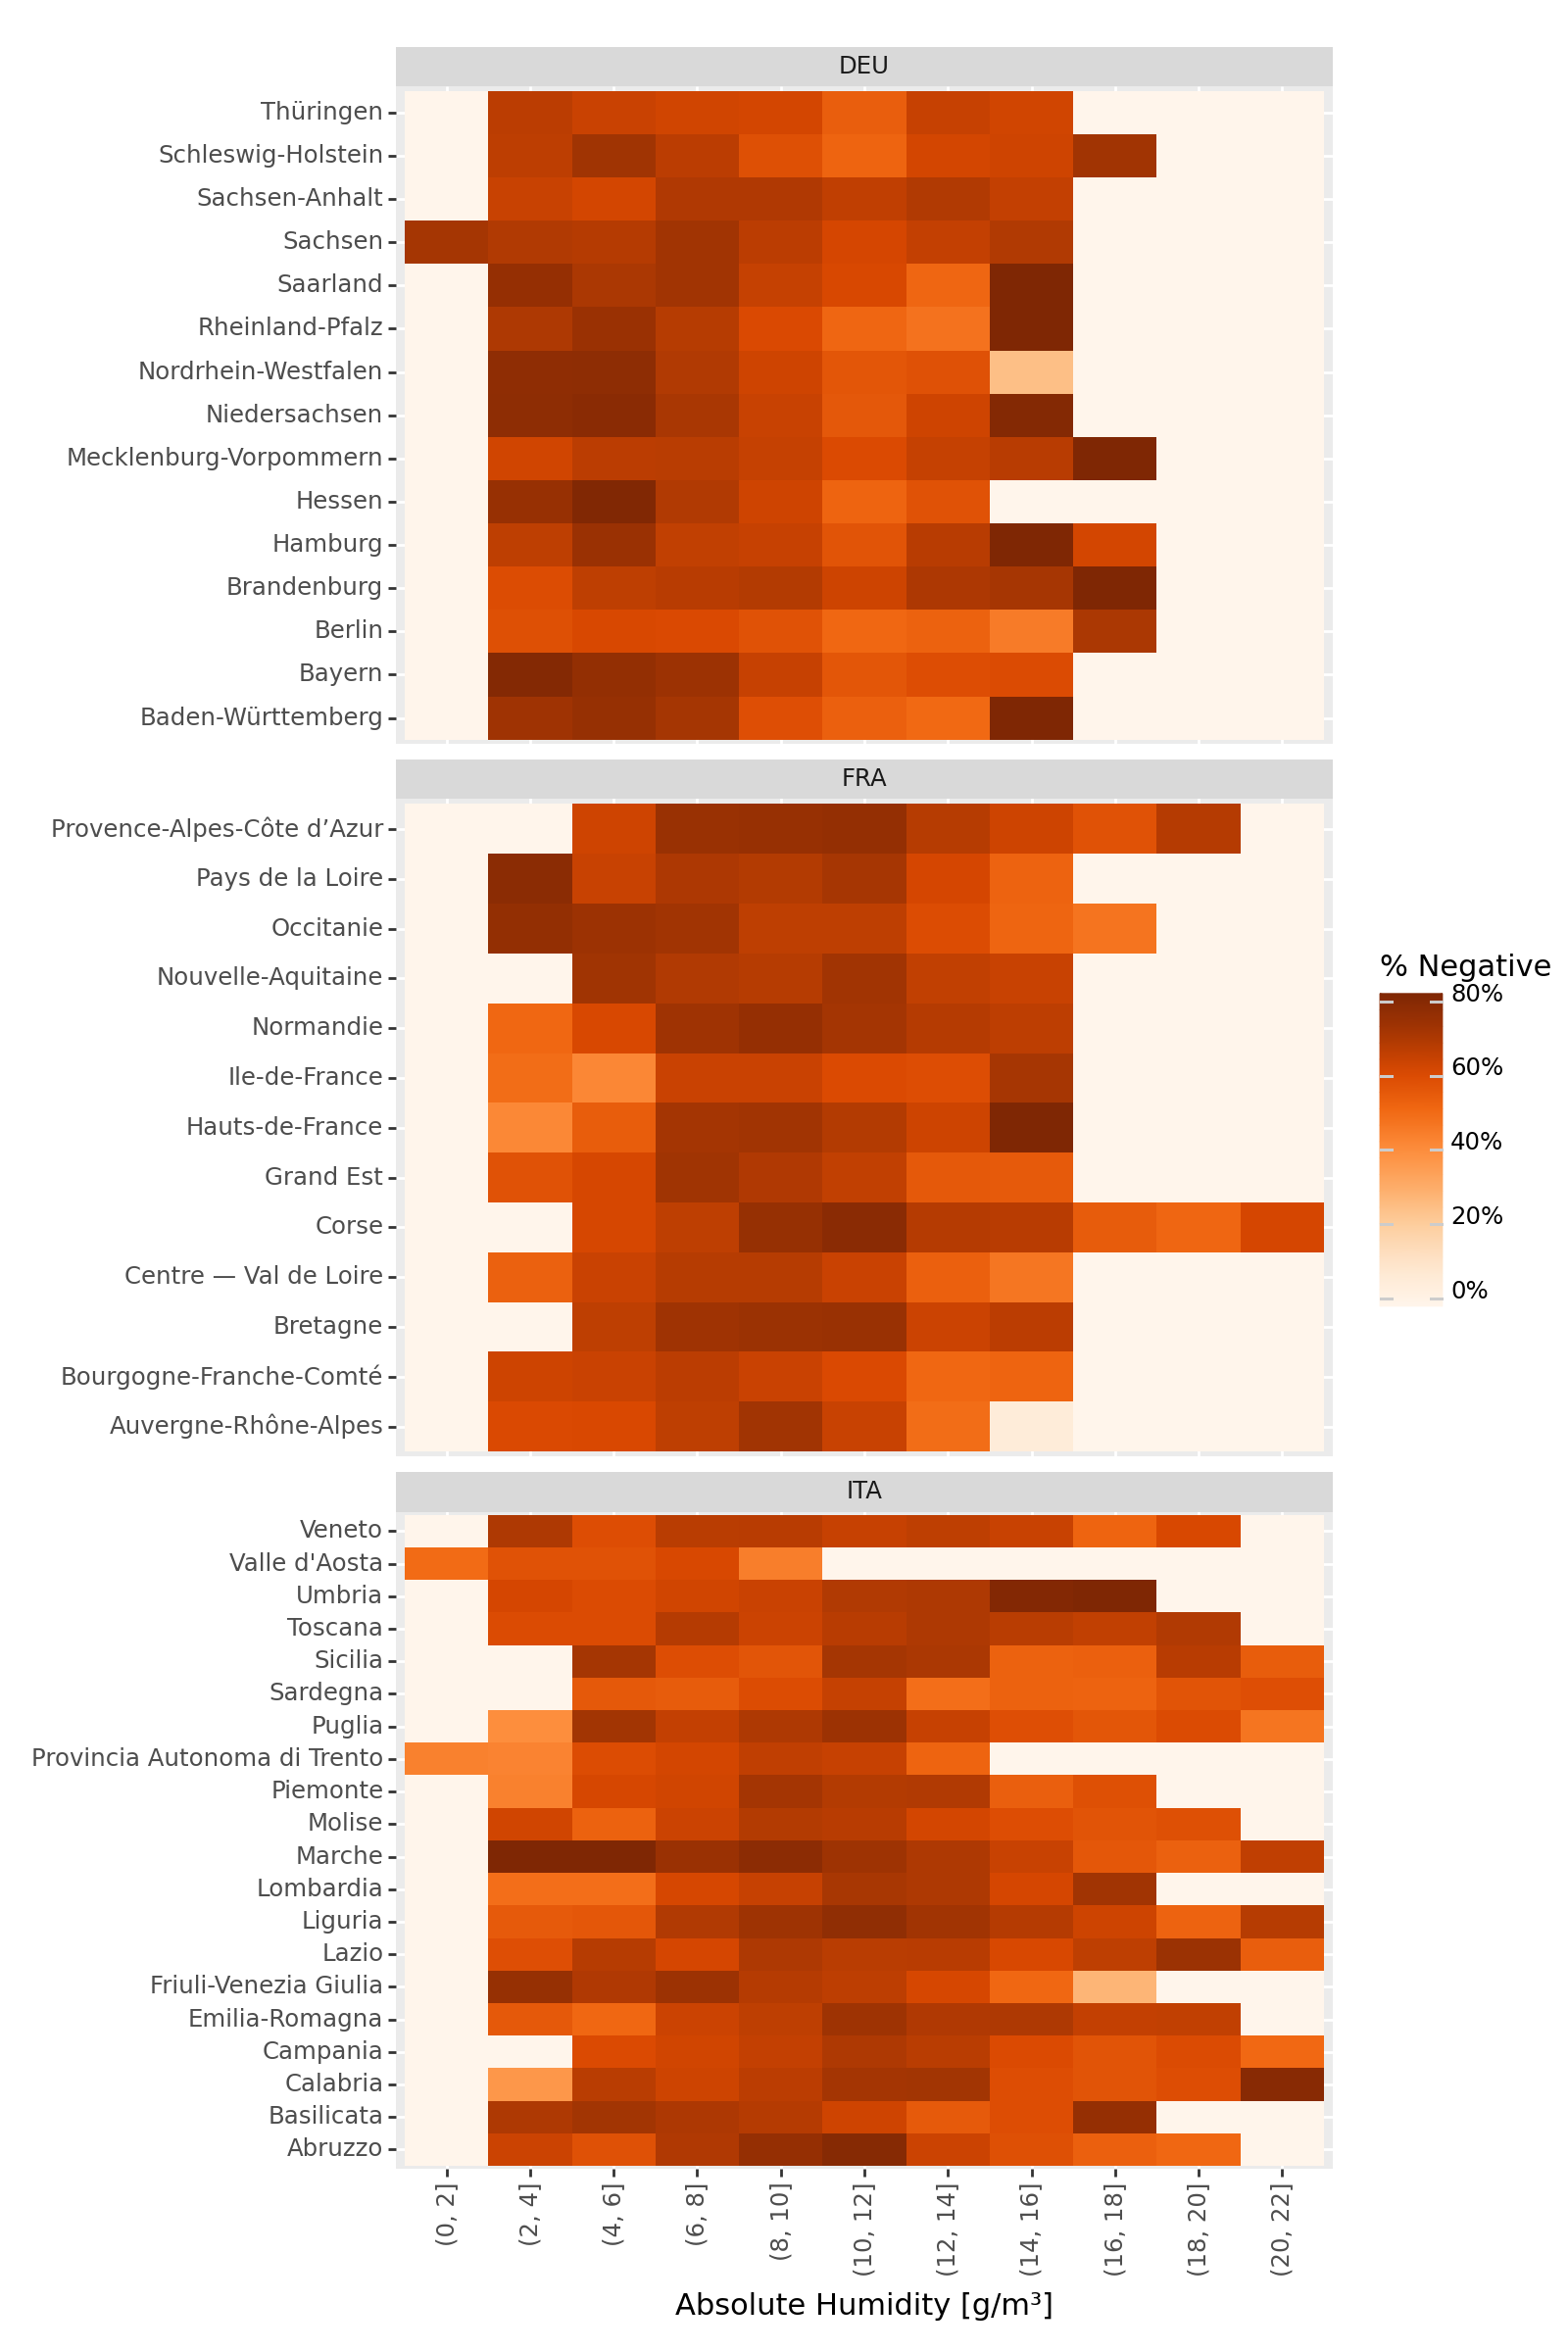

In [87]:
wv = 'absolute_humidity'

# Define the order for cat_value
cat_order = ['(0, 2]', '(2, 4]', '(4, 6]', '(6, 8]', '(8, 10]', '(10, 12]', '(12, 14]',
             '(14, 16]', '(16, 18]', '(18, 20]', '(20, 22]']

# Process the data
df = (
    ranges_df
    .loc[lambda dd: dd['var'] == wv]  # Filter by variable of interest
    .groupby(['cat_value', 'region', 'country'])
    .apply(lambda x: x.assign(n=x.loc[x['direction'] != 'NS', 'counts'].sum()))  # Calculate n excluding 'NS'
    .reset_index(drop=True)
    .assign(negative=lambda dd: dd.loc[dd['direction'] == 'Negative', 'counts'] / dd['n'])  # Calculate % Negative
    .loc[lambda dd: dd['direction'] == 'Negative']  # Filter for Negative direction only
    .fillna(value={'negative': 0})  # Replace NaN with 0 for % Negative
)

# Convert cat_value to a categorical type with a specified order
df['cat_value'] = pd.Categorical(df['cat_value'], categories=cat_order, ordered=True)

# Create the plot
plot = (p9.ggplot(df)
        + p9.aes('cat_value', 'region', fill='negative')
        + p9.geom_tile()
        + p9.facet_wrap('country', ncol=1, scales='free_y')
        + p9.theme(figure_size=(8, 12), axis_text_x=p9.element_text(rotation=90))
        + p9.scale_fill_continuous('Oranges', labels=percent_format(), limits=(0, 0.8))
        + p9.labs(x=CV_LABELS[wv], fill='% Negative', y='')
        )

# Display the plot
print(plot)